In [1]:

%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib import cm
from scipy.stats import multivariate_normal
from scipy import stats
import time
import math

import plotly.graph_objects as go


# from visuals import visualize_cigar
# from utils import gen_rnd_cov

def set_cam_poses():

    cam_poses = np.zeros((3,6)) # 3 cameras, 6 parameters
    
    # Cam 1
    cam_poses[0,0] = -0.099 # cam1:cx
    cam_poses[0,1] = 0.968 # cam1:cy
    cam_poses[0,2] = 1.363 # cam1:cz
    cam_poses[0,3] = (math.pi/180)*(-71.499) # cam1:alpha
    cam_poses[0,4] = (math.pi/180)*(16.753) # cam1:beta
    cam_poses[0,5] = (math.pi/180)*(-20.992) # cam1:gamma

    # Cam 2
    cam_poses[1,0] = -0.570 # cam2:cx
    cam_poses[1,1] = 0.970 # cam2:cy
    cam_poses[1,2] = 1.395 # cam2:cz
    cam_poses[1,3] = (math.pi/180)*(-62.113) # cam2:alpha
    cam_poses[1,4] = (math.pi/180)*(-42.374) # cam2:beta
    cam_poses[1,5] = (math.pi/180)*(-6.134) # cam2:gamma

    # Cam 3
    cam_poses[2,0] = -0.664 # cam3:cx
    cam_poses[2,1] =  0.979 # cam3:cy
    cam_poses[2,2] =  0.538 # cam3:cz
    cam_poses[2,3] = (math.pi/180)*(148.698)# cam3:alpha
    cam_poses[2,4] = (math.pi/180)*(-46.056)# cam3:beta
    cam_poses[2,5] = (math.pi/180)*(148.752)# cam3:gamma
    
    return cam_poses

def set_vir_poses(angles):
       
    vir_poses = np.zeros((3,6))

    # Cam 1
    vir_poses[0,0] = 0
    vir_poses[0,1] = 0
    vir_poses[0,2] = 0
    vir_poses[0,3] = (math.pi/180)*(angles[1,0])    # around X axis -->  ang(YZ)
    vir_poses[0,4] = (math.pi/180)*(-angles[0,0])   # around Y axis --> -ang(XZ)
    vir_poses[0,5] = 0 

    # Cam 2
    vir_poses[1,0] = 0
    vir_poses[1,1] = 0
    vir_poses[1,2] = 0
    vir_poses[1,3] = (math.pi/180)*(angles[1,1])    # around X axis -->  ang(YZ)
    vir_poses[1,4] = (math.pi/180)*(-angles[0,1])   # around Y axis --> -ang(XZ)
    vir_poses[1,5] = 0

    # Cam 3
    vir_poses[2,0] = 0
    vir_poses[2,1] = 0
    vir_poses[2,2] = 0
    vir_poses[2,3] = (math.pi/180)*(angles[1,2])    # around X axis -->  ang(YZ)
    vir_poses[2,4] = (math.pi/180)*(-angles[0,2])   # around Y axis --> -ang(XZ)
    vir_poses[2,5] = 0 

    
    
    return vir_poses

''' Translation Matrices'''
def get_transmats(cam_poses):
    
    mat_tran = np.zeros((4,4,3))
    for i in range(3): # Cam 1, 2, 3
        
        cx = cam_poses[i,0]
        cy = cam_poses[i,1]
        cz = cam_poses[i,2]

        # Transformation matrices (translation + rotations around x, y, z)
        mat_tran[:,:,i] = np.array([[1,0,0,cx],
                             [0,1,0,cy],
                             [0,0,1,cz],
                             [0,0,0,1]])
        
    return mat_tran
    
    
    
'''Rotation Matrices'''
def get_rotmats(cam_poses):
    
    mat_rota = np.zeros((3,3,3))
    for i in range(3): # Cam 1, 2, 3
        
        alpha = cam_poses[i,3]
        beta = cam_poses[i,4] 
        gamma = cam_poses[i,5]


        mat_rotx = np.array([[1,0,0],
                             [0,math.cos(alpha), -math.sin(alpha)],
                             [0, math.sin(alpha), math.cos(alpha)]])

        mat_roty = np.array([[math.cos(beta), 0, math.sin(beta)],
                             [0,1,0],
                             [-math.sin(beta), 0, math.cos(beta)]])


        mat_rotz = np.array([[math.cos(gamma), -math.sin(gamma), 0],
                             [math.sin(gamma), math.cos(gamma),0],
                             [0,0,1]])

        # General rotation matrix
        mat_rota[:,:,i] = mat_rotz.dot(mat_roty).dot(mat_rotx)
    
    
    return mat_rota

'''
This function defines object pose in B space starting from A space
It performs a full coordinate transformation (rotation and translation)
b2a is rotation matrix (3x3)
trl is translation matrix (4x4)
'''
def get_b_pose_from_a_pose(b2a, trl, a_pose):
        
    mat = np.zeros((4,4))
    b_pose = np.zeros(4) # coordinates|cameras
            
    mat [3,:] = trl[3,:]
    mat [:,3] = trl[:,3]
    mat[0:3, 0:3] = b2a[0:3,0:3]
        
    a2b = np.linalg.inv(mat)
    b_pose = a2b.dot(np.array([a_pose[0], a_pose[1], a_pose[2], 1]))
    
#     print("b_pose")
#     print(np.round(b_pose[0:3],3))

    return b_pose[0:3]

def get_angles(obj_pose):
    
    angles = np.zeros(2)
    
    angles[0] = (180/math.pi)*math.atan2((obj_pose[0]),(obj_pose[2])) + 180 # delta_x/delta_z
    angles[1] = (180/math.pi)*math.atan2((obj_pose[1]),(obj_pose[2])) + 180 # delta_y/delta_z

    if(angles[0]>180):
        angles[0] = 360-angles[0]
    if(angles[1]>180):
        angles[1] = 360-angles[1]
    if(angles[0]<-180):
        angles[0] = 360+angles[0]
    if(angles[1]<-180):
        angles[1] = 360+angles[1]

    if(obj_pose[0] < 0):
        angles[0] = -angles[0]
    if(obj_pose[1] < 0):
        angles[1] = -angles[1]

    return angles

        

def get_joint_rv(x, y, z, rv):
    
    p = rv.pdf([x, y, z])
    
        
    return p
    

def visualize_cigar(nb_pts, rv, mean, threshold, cmapper):
        
    x = np.linspace(stats.norm.ppf(0.02), stats.norm.ppf(0.98), nb_pts) + mean[0]
    y = np.linspace(stats.norm.ppf(0.02), stats.norm.ppf(0.98), nb_pts) + mean[1]
    z = np.linspace(stats.norm.ppf(0.02), stats.norm.ppf(0.98), nb_pts) + mean[2]

    # Getting joint probabilities
    start = time.time()
    p = np.zeros((nb_pts,nb_pts, nb_pts))
    for idx_x in range (nb_pts): # x, y, z
        for idx_y in range (nb_pts): # x, y, z
            for idx_z in range (nb_pts): # x, y, z   
                p[idx_x, idx_y, idx_z] = get_joint_rv(x[idx_x], y[idx_y], z[idx_z], rv)

    stop = time.time()
    elapsed = stop - start
    print("Joint probabilities obtained after: " + str(int(elapsed)) + " seconds.")

    # Creating figure
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes(projection="3d")

    idx = p > threshold

    # Creating plot
    xx, yy, zz = np.meshgrid(x, y, z)
    ax.scatter3D(xx[idx], yy[idx], zz[idx], c=p[idx], cmap=cmapper, vmin=0, vmax=10, marker='.')

    ax.set_xlabel('y')
    ax.set_ylabel('-x')
    ax.set_zlabel('z')
    
    
    max_x = mean[0]+2
    max_y = mean[1]+2
    max_z = mean[2]+2
    min_x = mean[0]-2
    min_y = mean[1]-2
    min_z = mean[2]-2
    
    ax.set_xlim([min_x, max_x])
    ax.set_ylim([min_y, max_y])
    ax.set_zlim([min_z, max_z])
    
    ax.view_init(0,180) # Top View
    
    plt.show()  
    
def new_visualize_cigar(nb_pts, rv, mean, threshold):
        
    x = np.linspace(stats.norm.ppf(0.02), stats.norm.ppf(0.98), nb_pts) + mean[0]
    y = np.linspace(stats.norm.ppf(0.02), stats.norm.ppf(0.98), nb_pts) + mean[1]
    z = np.linspace(stats.norm.ppf(0.02), stats.norm.ppf(0.98), nb_pts) + mean[2]
    
#     X, Y, Z = np.mgrid[-2:2:40j, -2:2:40j, -2:2:40j]

    # Getting joint probabilities
    start = time.time()
    p = np.zeros((nb_pts,nb_pts, nb_pts))
    for idx_x in range (nb_pts): # x, y, z
        for idx_y in range (nb_pts): # x, y, z
            for idx_z in range (nb_pts): # x, y, z   
                p[idx_x, idx_y, idx_z] = get_joint_rv(x[idx_x], y[idx_y], z[idx_z], rv)

    stop = time.time()
    elapsed = stop - start
    print("Joint probabilities obtained after: " + str(int(elapsed)) + " seconds.")

    
    
#     values = np.sin(X*Y*Z) / (X*Y*Z)

    xx, yy, zz = np.meshgrid(x, y, z)
    
    idx = p > threshold
    fig = go.Figure(data=go.Volume(
        x=xx.flatten(),
        y=yy.flatten(),
        z=zz.flatten(),
        value=p.flatten(),
        isomin=0.1,
        isomax=0.8,
        opacity=0.1, # needs to be small to see through all surfaces
        surface_count=17, # needs to be a large number for good volume rendering
        ))
    fig.show()


    
def visualize_all_cigars(nb_pts, rv_1, rv_2, rv_3, mean, threshold):
    
    # Creating figure
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes(projection="3d")
    cmappers = ['Greens', 'Blues', 'Reds']

    # Getting joint probabilities
    p = np.zeros((nb_pts,nb_pts, nb_pts))
    for k in range(3):
        
        if k == 0:
            rv = rv_1 
        if k == 1:
            rv = rv_2 
        if k == 2:
            rv = rv_3
        
        start = time.time()
        
        x_center = mean[0,k]
        y_center = mean[1,k]
        z_center = mean[2,k]
        
        x = np.linspace(stats.norm.ppf(0.05), stats.norm.ppf(0.95), nb_pts) + x_center
        y = np.linspace(stats.norm.ppf(0.05), stats.norm.ppf(0.95), nb_pts) + y_center
        z = np.linspace(stats.norm.ppf(0.05), stats.norm.ppf(0.95), nb_pts) + z_center
        for idx_x in range (nb_pts): # x, y, z
            for idx_y in range (nb_pts): # x, y, z
                for idx_z in range (nb_pts): # x, y, z   
                    p[idx_x, idx_y, idx_z] = get_joint_rv(x[idx_x], y[idx_y], z[idx_z], rv)

        stop = time.time()
        elapsed = stop - start
        print("Joint probabilities obtained after: " + str(int(elapsed)) + " seconds.")

        idx = p > threshold

        # Creating plot
        xx, yy, zz = np.meshgrid(x, y, z)
        ax.scatter3D(xx[idx], yy[idx], zz[idx], c=p[idx], cmap=cmappers[k], vmin=0, vmax=10, marker='.')
       
    ax.set_xlabel('y')
    ax.set_ylabel('-x')
    ax.set_zlabel('z') 
    
    max_x = np.mean(mean[0,:])+2
    max_y = np.mean(mean[1,:])+2
    max_z = np.mean(mean[2,:])+2
    min_x = np.mean(mean[0,:])-2
    min_y = np.mean(mean[1,:])-2
    min_z = np.mean(mean[2,:])-2
    
    ax.set_xlim([-1, 1.5])
    ax.set_ylim([-1, 1.5])
    ax.set_zlim([-1, 1.5])
    
    ax.view_init(0, 180) # Top View
    

    plt.show()  
    
    

if __name__ == '__main__':
    
    cam_id = 1
    nb_pts = 100
        
    # Stats in virtual space
    w_pose = np.array([-0.35, 0.1, 0.4])    
    
    # Get camera poses
    r_poses = set_cam_poses()
    
    # Get Rotation Matrices: real-cam to world 
    r2w = get_rotmats(r_poses)
    
    # Get Translation Matrices: real-cam to world
    r_trl = get_transmats(r_poses)
        
    # Get poses and angles of connecting ray vs Z axis in real-cam space
    r_poses = np.zeros((3,3))       
    r_angles = np.zeros((2,3))    
    for k in range(3):
        r_poses[:,k] = get_b_pose_from_a_pose(r2w[:,:,k], r_trl[:,:,k], w_pose)
        r_angles[0:2, k] = get_angles(r_poses[:,k])
            
    # Estimate virtual camera poses (in real camera space)
    v_poses = set_vir_poses(r_angles)
        
    # Get Rotation Matrices: virtual-cam to real-cam 
    v2r = get_rotmats(v_poses)
        
    # Get poses in virtual-cam space
    v_poses = np.zeros((3,3))  
    v_angles = np.zeros((2,3))    
    for k in range(3):
        v_poses[:,k] = get_b_pose_from_a_pose(v2r[:,:,k], np.identity(4), r_poses[:,k])
        v_angles[0:2, k] = get_angles(v_poses[:,k])
        # @TODO: The angles here should be exactly ZERO !!! WTF?!?!?
#         print(np.round(v_poses[:,k],3))        
#         print(v_angles[0:2, k])



    # THIS is the starting point (where the SNN sends predictions)

    # Original covariance matrix in virtual camera space
    μ = np.array([0,0,-0.8])
    Σ = np.array([[0.01,0,0],[0,0.01,0],[0,0,0.4]])
    
   
    r_μ = np.zeros((3,3))
    r_Σ = np.zeros((3,3,3))
    w_μ = np.zeros((3,3))
    w_Σ = np.zeros((3,3,3))
    new_μ = np.zeros((4,3)) # including a '1' at the end
    for k in range(3):
                 
        # @TODO: This is done only for testing purposes!
        μ[2] = v_poses[2,k]
#         print(μ)         
                     
        # Rotating Means from virtual-cam space to real-cam space  
        r_μ[:,k] = v2r[:,:,k] @ μ
                 
        # Rotating Means from real-cam space to world space 
        w_μ[:,k] = r2w[:,:,k] @ r_μ[:,k]
    
        # Translating Means from Camera (Real=Virtual) space to World space 
        new_μ[:,k] = r_trl[:,:, k] @ [w_μ[0,k], w_μ[1,k], w_μ[2,k],1]                     
                 
        # Rotating Covariance Matrix from virtual-cam space to real-cam space  
        r_Σ[:,:,k] = v2r[:,:,k] @ Σ @ v2r[:,:,k].T  
                 
        # Rotating Covariance Matrix from real-cam space to world space  
        w_Σ[:,:,k] = r2w[:,:,k] @ r_Σ[:,:,k] @ r2w[:,:,k].T 
    
    rv_1 = multivariate_normal(new_μ[0:3,0], w_Σ[:,:,0])
    rv_2 = multivariate_normal(new_μ[0:3,1], w_Σ[:,:,1])
    rv_3 = multivariate_normal(new_μ[0:3,2], w_Σ[:,:,2])
    

In [2]:
threshold = 2

<IPython.core.display.Javascript object>


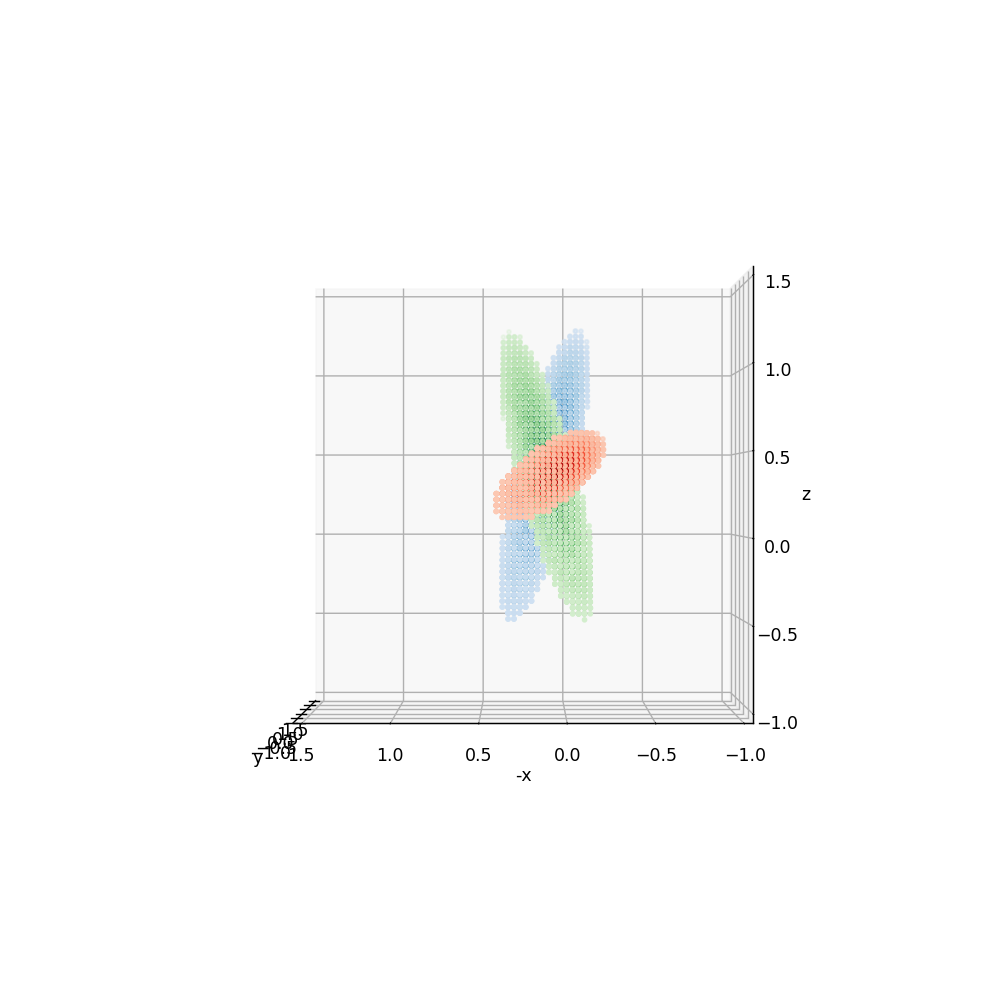

Joint probabilities obtained after: 23 seconds.
Joint probabilities obtained after: 23 seconds.
Joint probabilities obtained after: 23 seconds.


In [3]:
visualize_all_cigars(nb_pts, rv_1, rv_2, rv_3, new_μ[0:3,:], threshold)

Joint probabilities obtained after: 23 seconds.


<IPython.core.display.Javascript object>


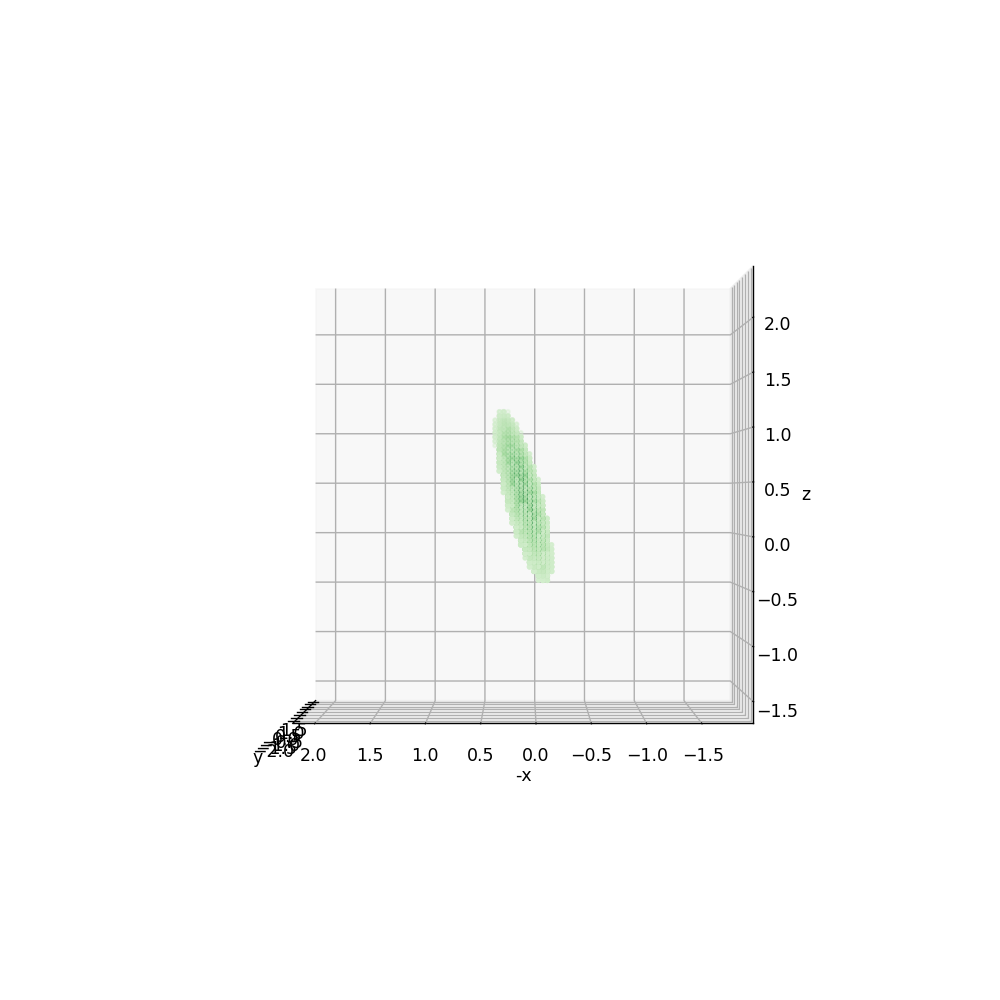

In [4]:
visualize_cigar(nb_pts, rv_1, new_μ[0:3,0], threshold, 'Greens')

Joint probabilities obtained after: 22 seconds.


<IPython.core.display.Javascript object>


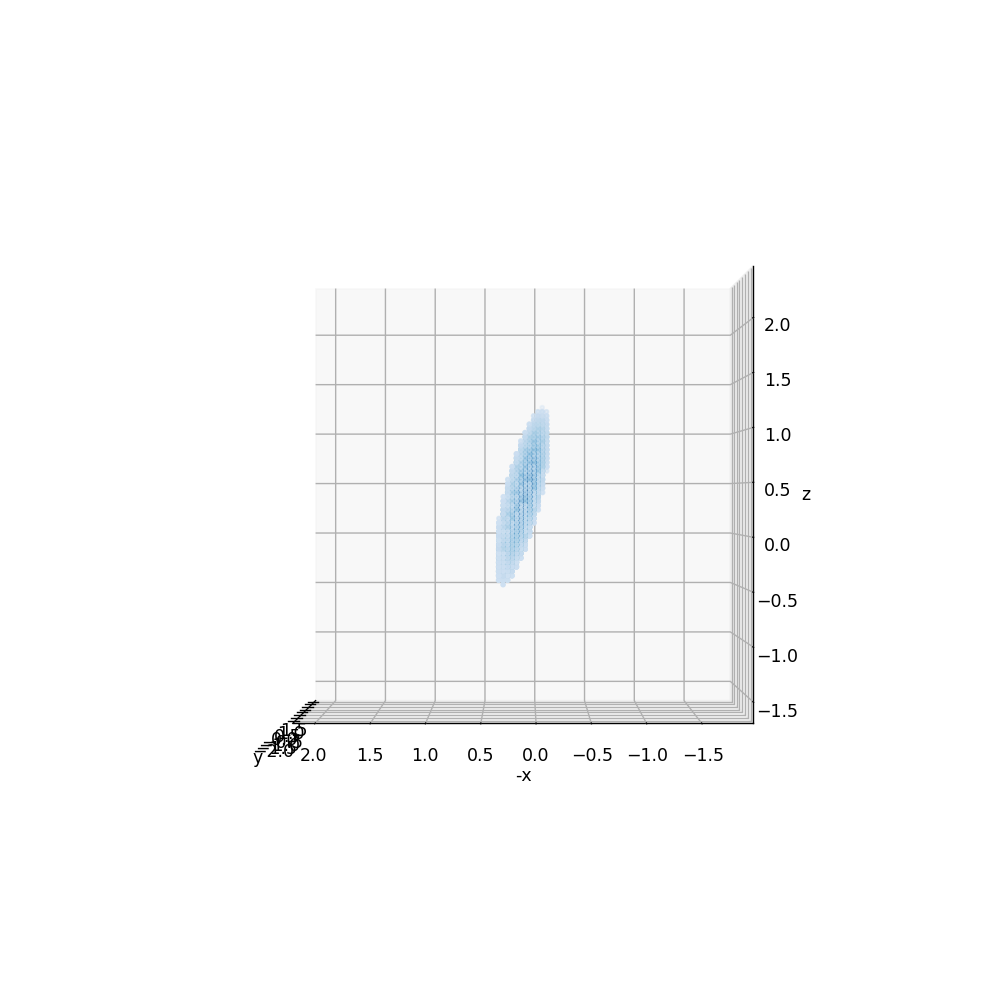

In [5]:
visualize_cigar(nb_pts, rv_2, new_μ[0:3,1], threshold, 'Blues')

Joint probabilities obtained after: 22 seconds.


<IPython.core.display.Javascript object>


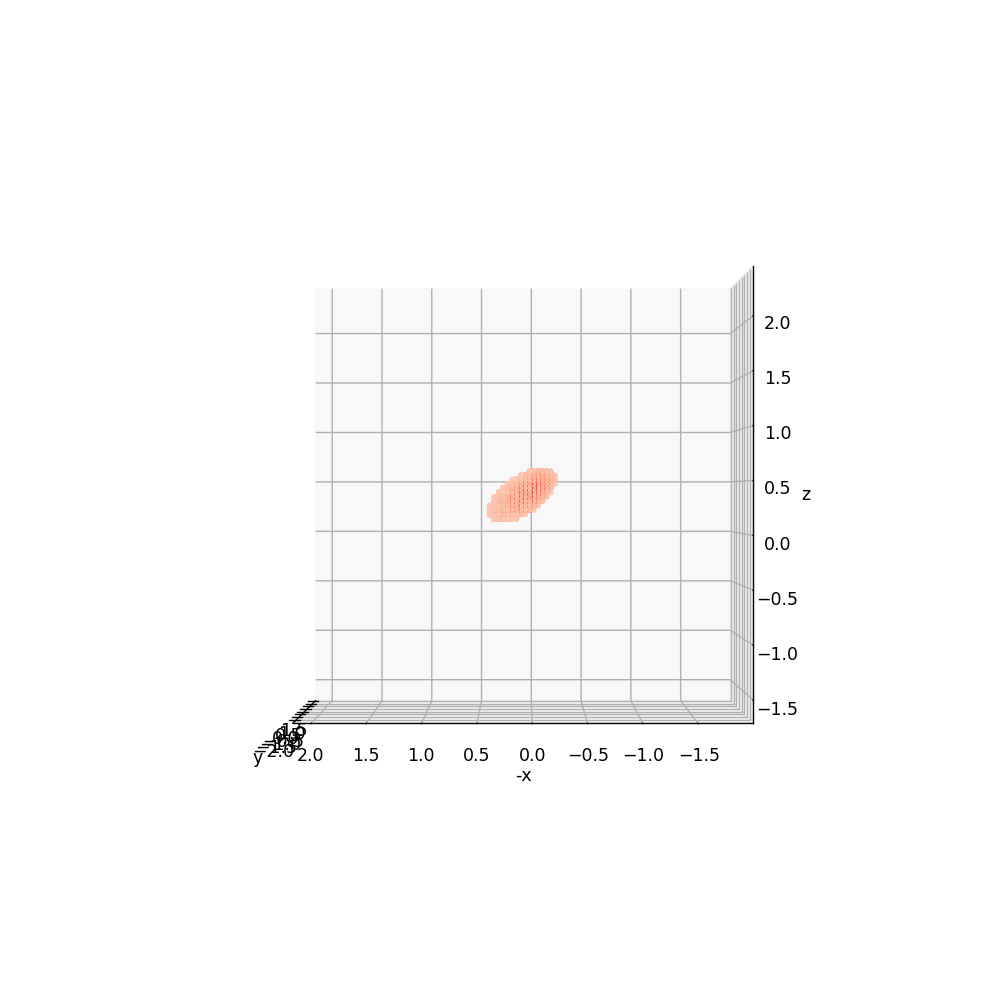

In [6]:
visualize_cigar(nb_pts, rv_3, new_μ[0:3,2], threshold, 'Reds')

In [7]:
# new_visualize_cigar(nb_pts, rv_1, new_μ[0:3,0], threshold)

In [8]:
# new_visualize_cigar(nb_pts, rv_2, new_μ[0:3,1], threshold)

In [9]:
# new_visualize_cigar(nb_pts, rv_3, new_μ[0:3,2], threshold)